In [1]:
!pip install scikit-activeml

In [2]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score , recall_score , precision_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from skactiveml.pool import UncertaintySampling , QueryByCommittee
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier

import matplotlib.pyplot as plt

In [3]:
import random

random.seed(42)

In [4]:
def UncertaintySampling_model(ml_model , X_train , X_test , y_train , y_test , batch_size =1 , n_cycle = 10 , method = "least_confident"):

  y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
  y[:10] = y_train[:10]
  clf = SklearnClassifier(
    ml_model,
    classes=np.unique(y_true),
    random_state=0
    )
  qs = UncertaintySampling(method = method)
  clf.fit(X_train, y)
  FIRST_ACC = accuracy_score(y_test, clf.predict(X_test))
  accuracies = []
  recalls  = []
  precisions = []
  n_samples = [100]
  for c in range(n_cycle):
    query_idx = qs.query(X=X_train, y=y, clf=clf , batch_size=batch_size)
    y[query_idx] = y_train[query_idx]
    clf.fit(X_train , y)
    accuracies.append(accuracy_score(y_test, clf.predict(X_test)))
    recalls.append(recall_score(y_test, clf.predict(X_test)))
    precisions.append(precision_score(y_test, clf.predict(X_test)))
    n_samples.append(n_samples[len(n_samples) - 1] + len(query_idx))
    # print(f'iteration number {c} : accuracy = {accuracy_score(y_true , clf.predict(x))}')

  plt.plot(range(1, n_cycle + 1), accuracies, label='Accuracy')
  plt.plot(range(1, n_cycle + 1), recalls, label='Recall')
  plt.plot(range(1, n_cycle + 1), precisions, label='Precision')
  plt.xlabel('Iterations')
  plt.ylabel('Scores')
  plt.title(f'Scores over Iterations in Active Learning with QueryByCommittee using {method} method')
  plt.legend()
  plt.grid(True)
  plt.show()

  return clf



In [5]:
def QueryByCommittee_model(ensemble_model , X_train , X_test , y_train , y_test , batch_size =1 , n_cycle = 10 , method = "KL_divergence"):

  y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
  y[:10] = y_train[:10]
  clf = SklearnClassifier(
    ensemble_model,
    classes=np.unique(y_true),
    random_state=0
    )
  qs = QueryByCommittee(method=method)

  clf.fit(X_train, y)
  FIRST_ACC = accuracy_score(y_test, clf.predict(X_test))
  accuracies = []
  recalls  = []
  precisions = []
  n_samples = [100]
  for c in range(n_cycle):
    query_idx = qs.query(X=X_train, y=y, ensemble=clf , batch_size=batch_size)
    y[query_idx] = y_train[query_idx]
    clf.fit(X_train , y)

    accuracies.append(accuracy_score(y_test, clf.predict(X_test)))
    recalls.append(recall_score(y_test, clf.predict(X_test)))
    precisions.append(precision_score(y_test, clf.predict(X_test)))

    n_samples.append(n_samples[len(n_samples) - 1] + len(query_idx))
    # print(f'iteration number {c} : accuracy = {accuracy_score(y_true , clf.predict(x))}')

  plt.plot(range(1, n_cycle + 1), accuracies, label='Accuracy')
  plt.plot(range(1, n_cycle + 1), recalls, label='Recall')
  plt.plot(range(1, n_cycle + 1), precisions, label='Precision')
  plt.xlabel('Iterations')
  plt.ylabel('Scores')
  plt.title(f'Scores over Iterations in Active Learning with QueryByCommittee using {method} method')
  plt.legend()
  plt.grid(True)
  plt.show()

  return clf



### Balanced Dataset

In [6]:
df = pd.read_csv('/content/drive/MyDrive/loan_approval_dataset.csv')


<Axes: >

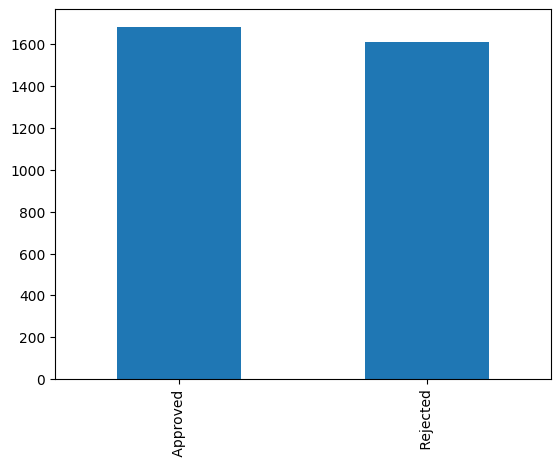

In [7]:
df[' loan_status'].value_counts().plot(kind = 'bar')

In [8]:
mapping = {' Yes': 1, ' No': 0}
df[' self_employed'].replace(mapping, inplace=True)

mapping = {' Not Graduate': 1, ' Graduate': 0}
df[' education'].replace(mapping, inplace=True)

mapping = {' Approved': 1, ' Rejected': 0}
df[' loan_status'].replace(mapping, inplace=True)

In [9]:
y_true = df[' loan_status'].copy().values

df.drop(columns = ['Unnamed: 0' , ' loan_status'] , inplace = True)
x = df.copy().values

In [10]:
X_train, X_test, y_train, y_test = train_test_split( x, y_true, test_size=0.10, random_state=42)

In [11]:
X_train.shape , X_test.shape

((2966, 12), (330, 12))

### Traditional ML model

In [12]:
clf = KNeighborsClassifier()
clf.fit(X_train , y_train)


print(f'Accuracy = {accuracy_score(clf.predict(X_test) , y_test)}')
print(f'Recall = {recall_score(clf.predict(X_test) , y_test)}')
print(f'Precision = {precision_score(clf.predict(X_test) , y_test)}')

Accuracy = 0.5060606060606061
Recall = 0.47770700636942676
Precision = 0.4807692307692308


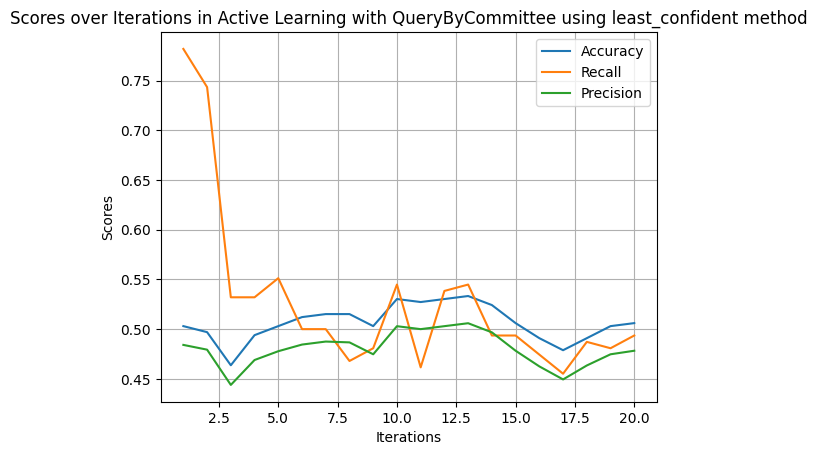

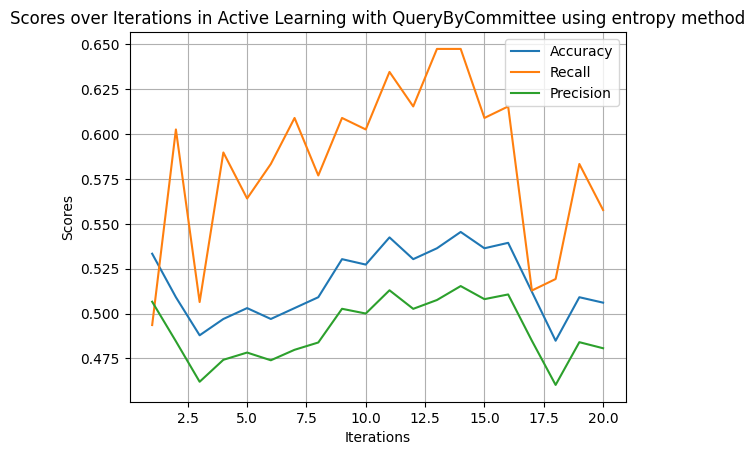

"



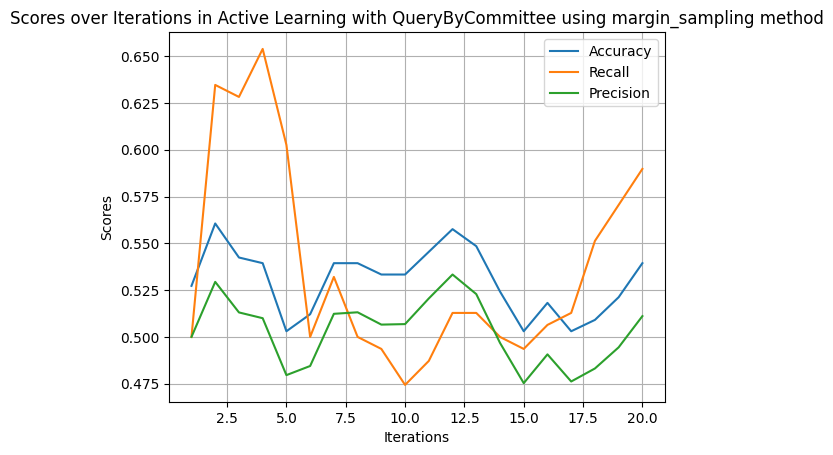

In [13]:
"""
 "least_confident",
  "margin_sampling",
  "entropy",
"""
clf = UncertaintySampling_model(KNeighborsClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='least_confident')
print('\n')

clf = UncertaintySampling_model(KNeighborsClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='entropy')
print('"\n')
clf = UncertaintySampling_model(KNeighborsClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='margin_sampling')
print('\n')


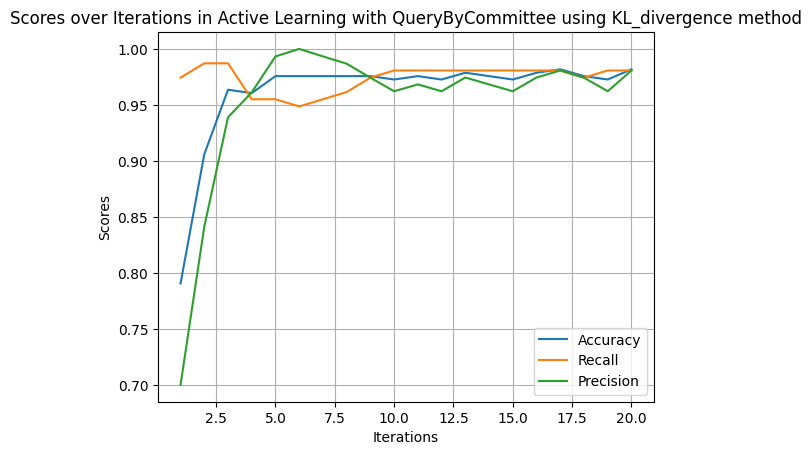

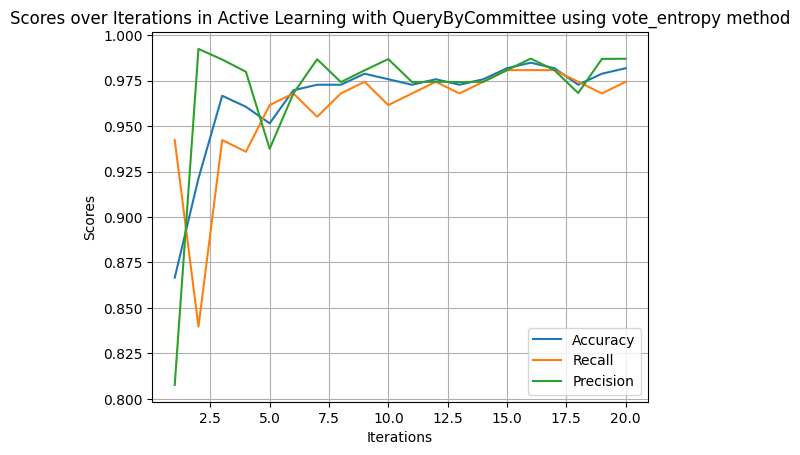

In [ ]:
"""
"KL_divergence", "vote_entropy"
"""
clf = QueryByCommittee_model(RandomForestClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='KL_divergence')
print('\n')

clf = QueryByCommittee_model(RandomForestClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='vote_entropy')
print('\n')



### imbalanced DATASET

In [14]:
df2 = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset.csv')

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


<Axes: >

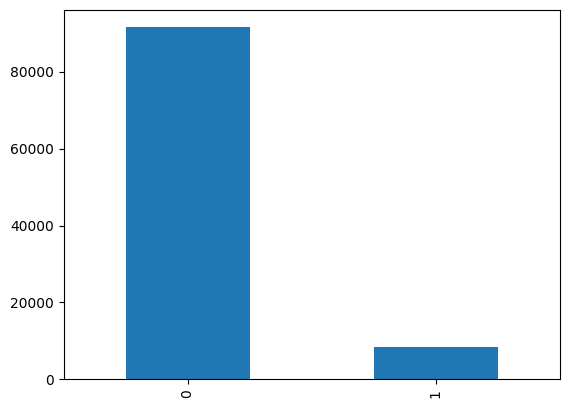

In [16]:
df2['diabetes'].value_counts().plot(kind = 'bar')

In [17]:
mapping = {'Female': 1, 'Male': 0 , 'Other': 2}

df2['gender'].replace(mapping , inplace = True)

mapping = {'No Info' : 0 , 'never':1 , 'former':2 , 'current':3 , 'not current':4 , 'ever':6}
df2['smoking_history'].replace(mapping , inplace = True)


In [18]:
y_true = df2['diabetes'].copy().values

df2.drop(columns = ['diabetes'] , inplace = True)
x = df2.copy().values

In [19]:
X_train, X_test, y_train, y_test = train_test_split( x, y_true, test_size=0.33, random_state=42)

In [20]:
X_train.shape , X_test.shape

((67000, 8), (33000, 8))

## Traditional ML Model

In [21]:
clf = RandomForestClassifier()
clf.fit(X_train , y_train)


print(f'Accuracy = {accuracy_score(clf.predict(X_test) , y_test)}')
print(f'Recall = {recall_score(clf.predict(X_test) , y_test)}')
print(f'Precision = {precision_score(clf.predict(X_test) , y_test)}')

Accuracy = 0.9704848484848485
Recall = 0.9525
Precision = 0.6842672413793104


In [22]:
X_train.shape

(67000, 8)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


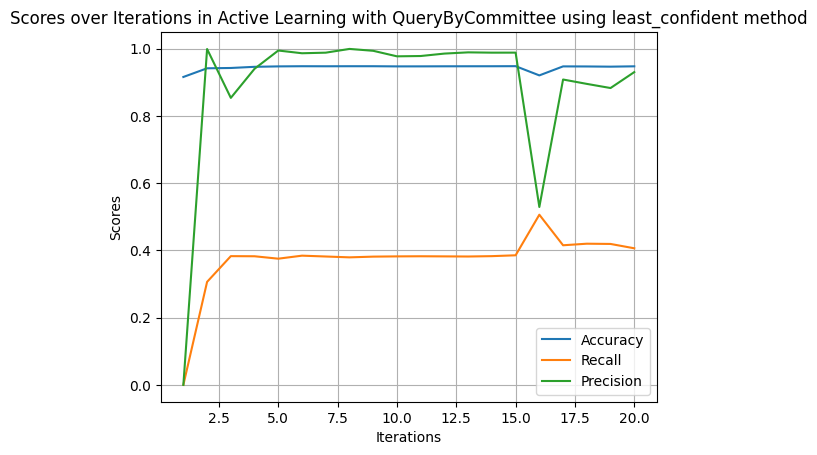

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


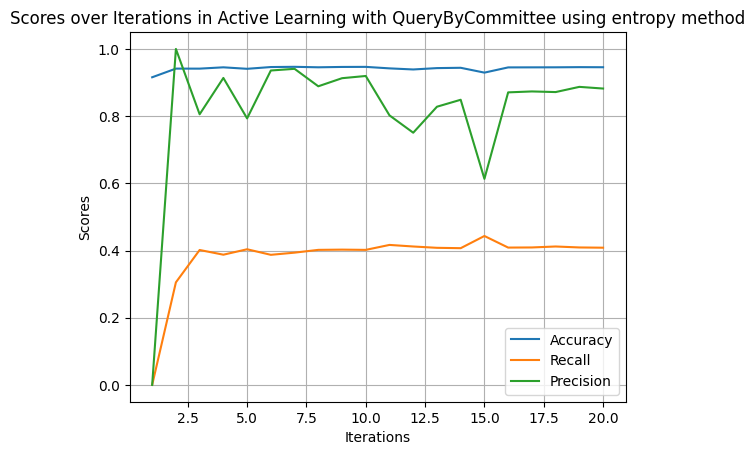

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


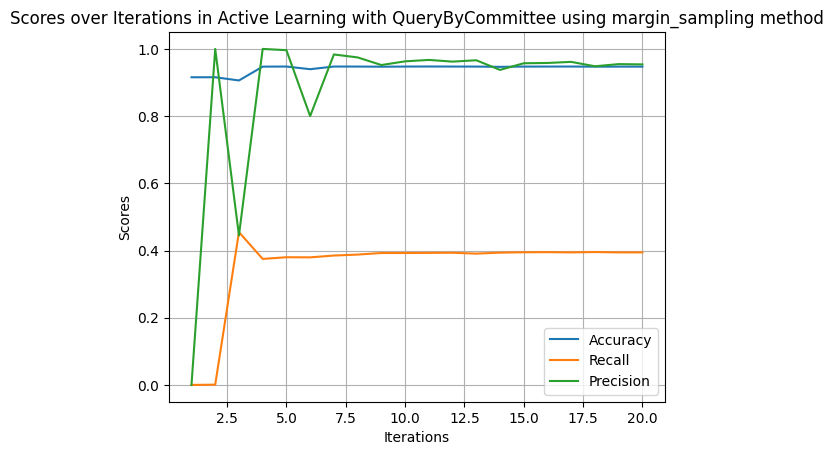

In [23]:
"""
 "least_confident",
  "margin_sampling",
  "entropy",
"""
clf = UncertaintySampling_model(KNeighborsClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='least_confident')
print('\n')

clf = UncertaintySampling_model(KNeighborsClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='entropy')
print('\n')
clf = UncertaintySampling_model(KNeighborsClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='margin_sampling')
print('\n')


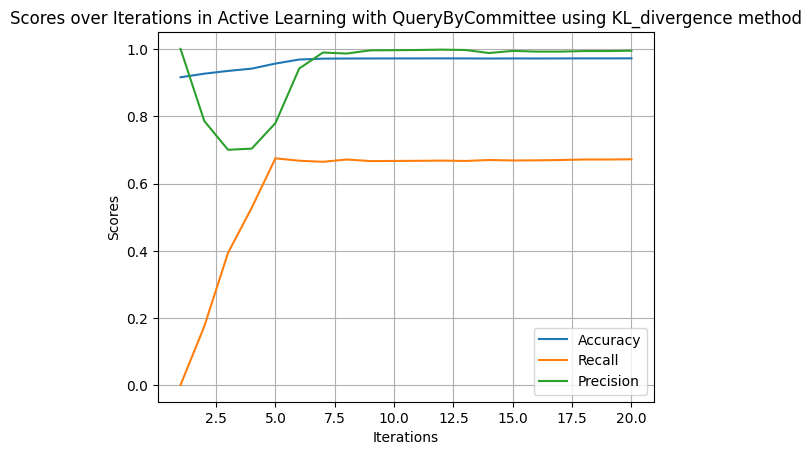

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


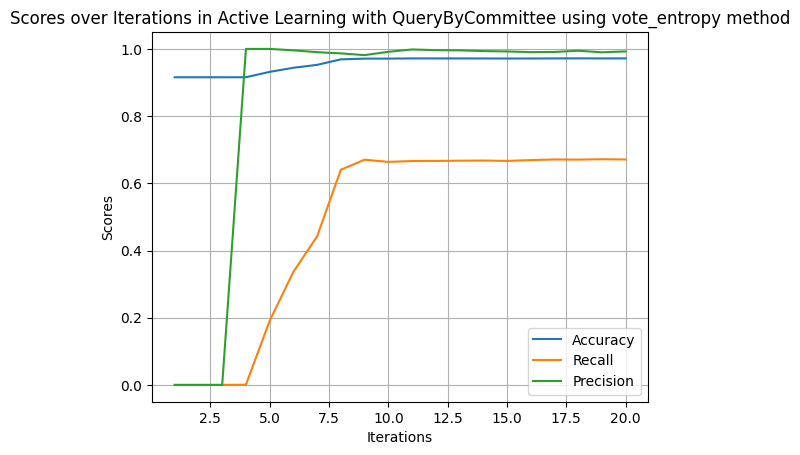

In [24]:
"""
"KL_divergence", "vote_entropy"
"""
clf = QueryByCommittee_model(RandomForestClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='KL_divergence')
print('\n')

clf = QueryByCommittee_model(RandomForestClassifier(),
                                X_train, X_test, y_train, y_test ,
                                batch_size=20,
                                n_cycle=20,
                                method='vote_entropy')
print('\n')

